In [18]:
# Core libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Libraries for data preprocessing and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Libraries for building the deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Library for plotting and visualization
import matplotlib.pyplot as plt

# Setting a style for the plots
plt.style.use('fivethirtyeight')

/var/folders/bx/mls3rqkd38xdt5djlrdbsgf40000gn/T/ipykernel_20454/418819485.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('TSLA_stock_data.csv', index_col=0, parse_dates=True)
/var/folders/bx/mls3rqkd38xdt5djlrdbsgf40000gn/T/ipykernel_20454/418819485.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


--- Initial Data Inspection ---
Data type of the index: object

Missing values have been filled.

Plotting the cleaned historical data with proper dates...


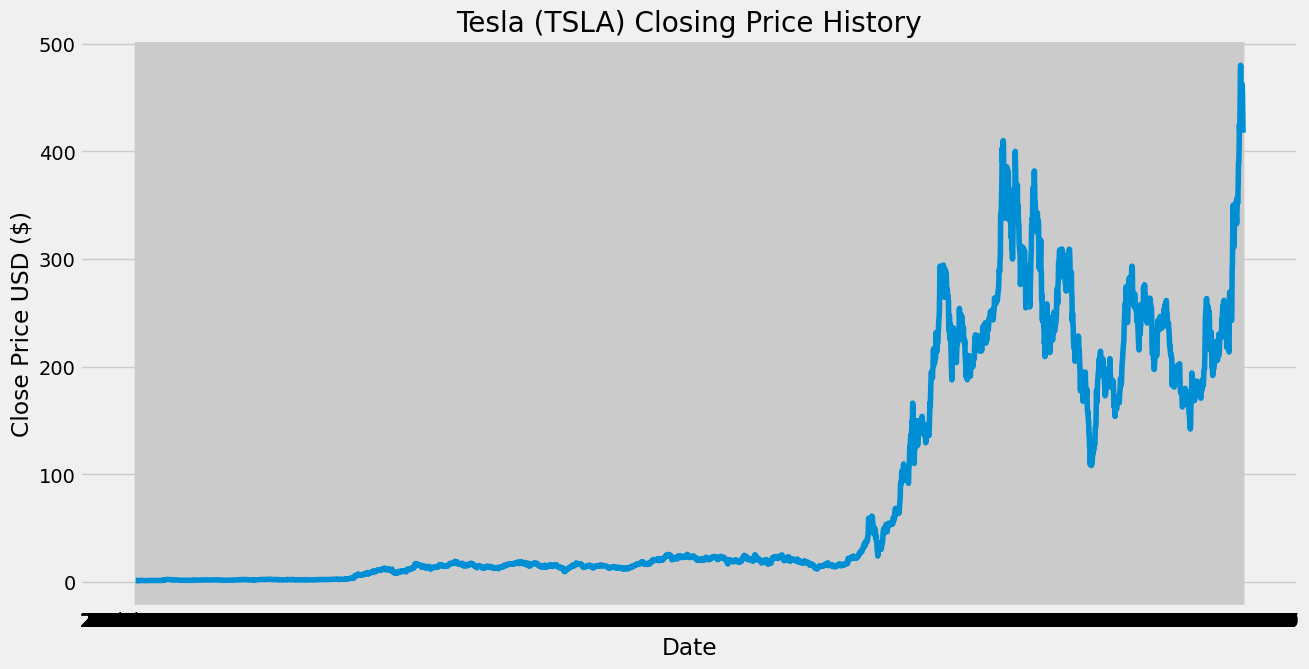

In [19]:
# --- FIX: Read the unnamed first column as the date index ---
# index_col=0: Use the first column as the DataFrame index.
# parse_dates=True: Attempt to convert the index to datetime objects.
df = pd.read_csv('TSLA_stock_data.csv', index_col=0, parse_dates=True)


print("--- Initial Data Inspection ---")
# The index should now be a DatetimeIndex
print("Data type of the index:", df.index.dtype)


# --- Clean the 'Close' column (this is still important) ---
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

if df['Close'].isnull().sum() > 0:
    print(f"\nWarning: Found {df['Close'].isnull().sum()} non-numeric rows in 'Close' column.")
    df.fillna(method='ffill', inplace=True)
    print("Missing values have been filled.")


# --- Plotting the Cleaned Data ---
print("\nPlotting the cleaned historical data with proper dates...")
plt.figure(figsize=(14, 7))
plt.title('Tesla (TSLA) Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date') # Now we can use 'Date' as the label
plt.ylabel('Close Price USD ($)')
plt.show()

In [21]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Define the training data size (80% of the data)
training_data_len = int(np.ceil(len(dataset) * .8))

# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Create the time-series dataset for training
X_train = []
y_train = []

# Use a 60-day window of historical data to predict the next day
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training data to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into the 3D format required by LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Build the LSTM model architecture
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model for training
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model's architecture
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model using the fit method
print("\nTraining the model...")
history = model.fit(X_train, y_train, batch_size=32, epochs=25)
print("Model training complete.")


Training the model...
Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: nan
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: nan
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: nan
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: nan
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: nan
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: nan
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: nan
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: nan
Epoch 9/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: nan
Epoch 10/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: nan
Epoch 11/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: nan
Epoch 12/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: nan
Epoch 13/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: nan
Epoch 14/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: nan
Epoch 15/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: nan
Epoch 16/25
90/90 ━━━━━━━━

In [24]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Convert the test data to a numpy array
X_test = np.array(X_test)

# Reshape the data for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the model's predicted price values
print("\nMaking predictions on the test data...")
predictions = model.predict(X_test)

# Undo the scaling to get actual price predictions
predictions = scaler.inverse_transform(predictions)
print("Predictions generated.")


Making predictions on the test data...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Predictions generated.



Root Mean Squared Error (RMSE): nan


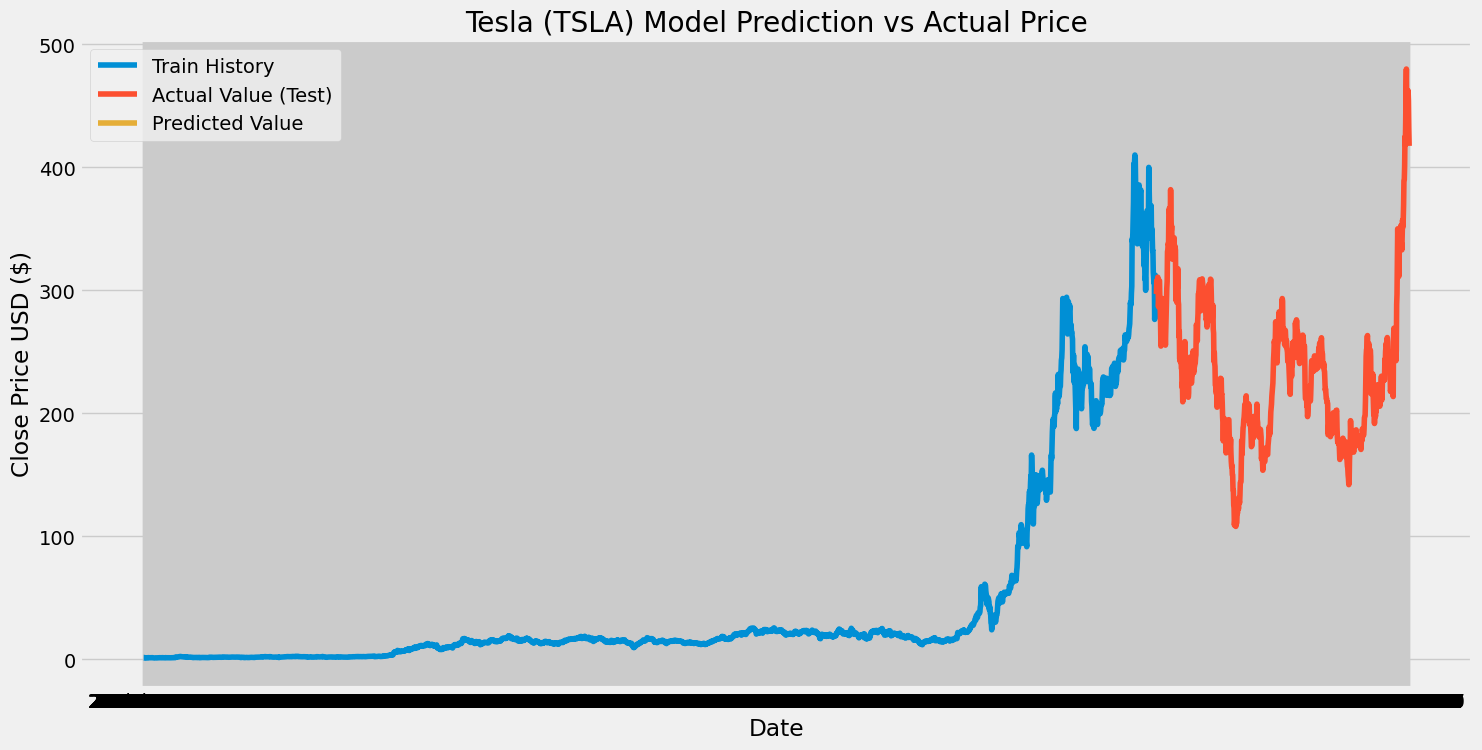


Validation Data with Predictions (Last 10 Days):
                 Close  Predictions
Price                              
2024-12-16  463.019989          NaN
2024-12-17  479.859985          NaN
2024-12-18  440.130005          NaN
2024-12-19  436.170013          NaN
2024-12-20  421.059998          NaN
2024-12-23  430.600006          NaN
2024-12-24  462.279999          NaN
2024-12-26  454.130005          NaN
2024-12-27  431.660004          NaN
2024-12-30  417.410004          NaN


In [25]:
# This step assumes you have already run the unchanged Steps 3 through 6.

# Calculate the Root Mean Squared Error (RMSE) for evaluation
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'\nRoot Mean Squared Error (RMSE): {rmse}') # This value will be the same

# Prepare data for the result plot
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

# Visualize the model's performance with a proper Date axis
plt.figure(figsize=(16, 8))
plt.title('Tesla (TSLA) Model Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close']) # Plotting training data
plt.plot(valid[['Close', 'Predictions']]) # Plotting actual and predicted values
plt.legend(['Train History', 'Actual Value (Test)', 'Predicted Value'])
plt.show()

# Display the last part of the validation with predictions
print("\nValidation Data with Predictions (Last 10 Days):")
print(valid.tail(10))